In [170]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [171]:
from utils import categorical_accuracy, print_scores

In [172]:
import time
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext

from gensim.models.keyedvectors import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder

import random
import string
import copy

from mlflow import log_metric, log_param, log_artifacts, mlflow
from tqdm import tqdm, notebook, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
RANDOM_SEED = 123
GLOVE = 1 #Whether to use GloVe vectors or not
GLOVE_DIM = 200
HIDDEN_SIZE = 640
BATCH_SIZE = 512
EPOCHS = 50
LEARNING_RATE = 0.001
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_SEQ_LEN = 150
MAX_FEATURES = 5000#10000
column = 'lyrics_nsw_alpha_en'
NUM_LAYERS = 1
TRAIN_SPLIT = 0.7

torch.manual_seed(RANDOM_SEED)

In [199]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

In [200]:
df = pd.read_pickle("./nlp_genre/df_bal_kayla.pkl")
df_test = pd.read_pickle("./nlp_genre/df_test_kayla.pkl")

In [201]:
# full_df = pd.concat([df[['lyrics_nsw_alpha_en', 'Genre']], df_test[['lyrics_nsw_alpha_en', 'Genre']]], axis=0).reset_index(drop=True)
full_df = pd.concat([df[[column, 'Genre']], df_test[[column, 'Genre']]], axis=0).reset_index(drop=True)

In [202]:
full_df.head()

,lyrics_nsw_alpha_en,Genre
0,written baby baby treat bad best boy ever wan ...,Rock
1,saw yesterday shaved body play know fine ca ge...,Rock
2,wan na add subtract put take less back multipl...,Rock
3,well aware happiness get simple struggle survi...,Rock
4,met day feeling usual guess could say sale tak...,Rock


In [203]:
full_df = full_df[~full_df['Genre'].isin(['Indie', 'Folk'])]

In [204]:
full_df.shape

(43837, 2)

In [205]:
le = LabelEncoder()
y = torch.tensor(le.fit_transform(full_df['Genre']))

In [206]:
class Sequences(Dataset):
    def __init__(self, path, y, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        self.vectorizer = CountVectorizer(max_features = MAX_FEATURES)# min_df = 0.00001, max_df = 0.8)
        self.vectorizer.fit(df[column].tolist())
        self.token2idx = self.vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        # self.token2idx['<UNK>'] = max(self.token2idx.values()) + 1

        tokenizer = self.vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx] # Encode sentences to list of numbers based on token2idx
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df[column].tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df['Genre'].tolist()) if sequence])
        self.labels = y
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [207]:
dataset = Sequences(full_df, y, max_seq_len=MAX_SEQ_LEN)

In [208]:
len(list(dataset.token2idx.values())) # All values are continuous

5001

In [209]:
if os.path.isfile('./glove'+str(GLOVE_DIM)+'.pth'):
    glove = torch.load('glove'+str(GLOVE_DIM)+'.pth')
else:
    glove = torchtext.vocab.GloVe(name='6B', dim=GLOVE_DIM)
    torch.save(glove, 'glove'+str(GLOVE_DIM)+'.pth')

In [210]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [211]:
get_word('google').shape

torch.Size([200])

In [212]:
matrix_len = len(dataset.token2idx)
weights_matrix = np.zeros((matrix_len, GLOVE_DIM))
words_found = 0

for i, word in enumerate(dataset.token2idx):
    try: 
        weights_matrix[i] = get_word(word)
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(GLOVE_DIM, ))

if torch.cuda.is_available():
    weights_matrix = torch.from_numpy(weights_matrix)

In [213]:
weights_matrix[0].shape

torch.Size([200])

In [214]:
train_split = TRAIN_SPLIT
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [215]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True)#, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True)#, num_workers = 2)

In [216]:
class LSTM(nn.Module):
    def __init__(
        self,
        batch_size,
        vocab_size = None,
        weights_matrix = None,
        embedding_dimension=50,
        hidden_size=64, 
        n_layers=1,
        device=device,
        dropout=0.4,
        bidirectional=BIDIRECTIONAL
    ):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.directions = 2 if self.bidirectional else 1

        if weights_matrix is not None:
            self.encoder, num_embeddings, embedding_dimension = self.create_emb_layer(weights_matrix, True)
        else:
            self.encoder = nn.Embedding(vocab_size, embedding_dimension)

        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.fc1 = nn.Linear(hidden_size*self.directions, 640)
        self.relu =nn.ReLU()
        self.do = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(640, 320)
        self.fc3 = nn.Linear(320, 64)
        self.decoder = nn.Linear(64, 4)
        # self.sm = nn.Softmax(1)

    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.shape
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})

        if non_trainable:
            emb_layer.weight.requires_grad = False

        return emb_layer, num_embeddings, embedding_dim

    def init_hidden(self):
        h0 = torch.randn(self.n_layers*self.directions, self.batch_size, self.hidden_size).to(self.device)
        c0 = torch.randn(self.n_layers*self.directions, self.batch_size, self.hidden_size).to(self.device)
        return (h0, c0)

    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        h0, c0 = self.init_hidden()
        encoded = self.encoder(inputs) # 512x128 -> 512x128x100

        output, (hidden, cell) = self.rnn(encoded, (h0, c0)) #512x128x100 -> 512x128x128
        # output[x, -1, y] is same as hidden
        # output is the collection of hidden states at each time step; hidden is the hidden state at the final time step
        # print(hidden.shape)
        if self.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
            hidden = hidden[-1,:,:].squeeze_(0)
        # print(hidden.shape)
        hidden = self.fc1(hidden)
        hidden = self.relu(hidden)
        hidden = self.do(hidden)
        hidden = self.fc2(hidden)
        hidden = self.relu(hidden)
        hidden = self.fc3(hidden)
        hidden = self.relu(hidden)
        hidden = self.decoder(hidden).squeeze()
        return hidden

In [217]:
if GLOVE:
    model = LSTM(
        hidden_size=HIDDEN_SIZE,
        weights_matrix = weights_matrix,
        device=device,
        batch_size=batch_size,
        bidirectional=BIDIRECTIONAL,
        embedding_dimension=GLOVE_DIM,
        dropout = DROPOUT,
        n_layers = NUM_LAYERS
    )
else:
    model = LSTM(
        hidden_size=256,
        vocab_size=len(dataset.token2idx),
        device=device,
        batch_size=batch_size,
        bidirectional=BIDIRECTIONAL,
        dropout = DROPOUT
    )
model = model.to(device)
model = nn.DataParallel(model)
model

DataParallel(
  (module): LSTM(
    (encoder): Embedding(5001, 200)
    (rnn): LSTM(200, 640, batch_first=True, bidirectional=True)
    (fc1): Linear(in_features=1280, out_features=640, bias=True)
    (relu): ReLU()
    (do): Dropout(p=0.3, inplace=False)
    (fc2): Linear(in_features=640, out_features=320, bias=True)
    (fc3): Linear(in_features=320, out_features=64, bias=True)
    (decoder): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [218]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)

In [219]:
def train(model, train_loader, confusion=None):
    model.train()
    progress_bar = notebook.tqdm(train_loader, leave=False)
    train_batch_losses = []
    train_batch_accuracy = []
    total = 0

    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(inputs).to(device)
        # print(output.shape, target.shape)
        loss = criterion(output, target)
        acc = categorical_accuracy(output, target, device)

        loss.backward()

        # nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()

        progress_bar.set_description(f'Loss: {loss.item():.3f}')

        train_batch_losses.append(loss.item())
        train_batch_accuracy.append(acc.item())
        total += 1

    if confusion:
        print_scores(target.cpu().clone().detach().numpy(), output.argmax(dim=1, keepdim=True).squeeze().cpu().clone().detach().numpy(), le.classes_)
        # pass

    return train_batch_losses, train_batch_accuracy, total

In [220]:
def evalu(model, test_loader, confusion=None):
    model.eval()
    progress_bar = notebook.tqdm(test_loader, leave=False)
    eval_batch_loss = []
    eval_batch_acc = []
    total = 0

    with torch.no_grad():
        for inputs, target in progress_bar:
            inputs, target = inputs.to(device), target.to(device)
            predictions = model(inputs)

            loss = criterion(predictions, target)

            acc = categorical_accuracy(predictions, target, device)

            eval_batch_loss.append(loss.item())
            eval_batch_acc.append(acc.item())
            total += 1
    if confusion:
        print_scores(target.cpu().clone().detach().numpy(), predictions.argmax(dim=1, keepdim=True).squeeze().cpu().clone().detach().numpy(), le.classes_)
        pass
    return eval_batch_loss, eval_batch_acc, total

  0%|          | 0/60 [00:00<?, ?it/s]

/opt/miniconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #1	Train Loss: 1.351 	Train Accuracy: 0.313
Epoch #1	Eval Loss: 1.339 	Eval Accuracy: 0.308


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #6	Train Loss: 1.336 	Train Accuracy: 0.318
Epoch #6	Eval Loss: 1.332 	Eval Accuracy: 0.327


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #11	Train Loss: 1.338 	Train Accuracy: 0.313
Epoch #11	Eval Loss: 1.334 	Eval Accuracy: 0.324


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #16	Train Loss: 1.318 	Train Accuracy: 0.354
Epoch #16	Eval Loss: 1.307 	Eval Accuracy: 0.372


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #21	Train Loss: 1.134 	Train Accuracy: 0.508
Epoch #21	Eval Loss: 1.128 	Eval Accuracy: 0.513


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #26	Train Loss: 1.037 	Train Accuracy: 0.561
Epoch #26	Eval Loss: 1.083 	Eval Accuracy: 0.537


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.984 	Train Accuracy: 0.588
Epoch #31	Eval Loss: 1.053 	Eval Accuracy: 0.553


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #36	Train Loss: 0.930 	Train Accuracy: 0.618
Epoch #36	Eval Loss: 1.036 	Eval Accuracy: 0.562


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #41	Train Loss: 0.894 	Train Accuracy: 0.638
Epoch #41	Eval Loss: 1.048 	Eval Accuracy: 0.560


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch #46	Train Loss: 0.859 	Train Accuracy: 0.653
Epoch #46	Eval Loss: 1.040 	Eval Accuracy: 0.570


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

/opt/miniconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


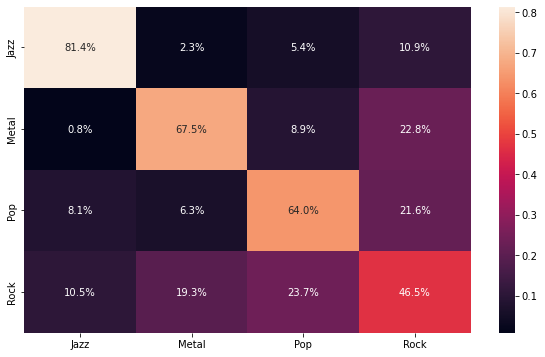

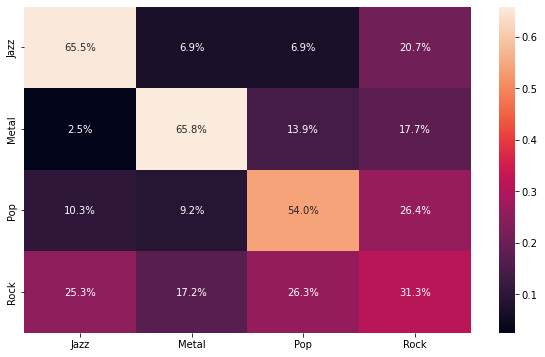

In [221]:
train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []
confusion = False
for epoch in range(EPOCHS):
    if epoch == EPOCHS-1:
        confusion = True
    train_batch_losses, train_batch_accuracy, total = train(model, train_loader, confusion)
    eval_batch_loss, eval_batch_acc, total_ = evalu(model, test_loader, confusion)

    
    train_epoch_loss = sum(train_batch_losses) / total
    train_epoch_acc = sum(train_batch_accuracy) / total
    
    eval_epoch_loss = sum(eval_batch_loss) / total_
    eval_epoch_acc = sum(eval_batch_acc) / total_
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    
    eval_losses.append(eval_epoch_loss)
    eval_accuracy.append(eval_epoch_acc)
    
    if epoch % 5 == 0:
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {train_epoch_loss:.3f} \tTrain Accuracy: {train_epoch_acc:.3f}')
        tqdm.write(f'Epoch #{epoch + 1}\tEval Loss: {eval_epoch_loss:.3f} \tEval Accuracy: {eval_epoch_acc:.3f}')

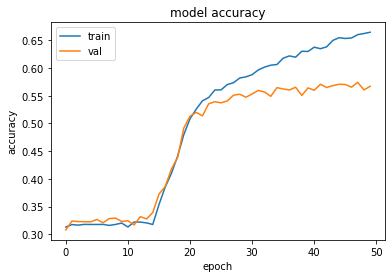

In [222]:
plt.plot(train_accuracy)
plt.plot(eval_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [223]:
with mlflow.start_run():
    log_param("GLOVE", GLOVE)
    log_param("GLOVE_DIM", GLOVE_DIM)
    log_param("HIDDEN_SIZE", HIDDEN_SIZE)
    log_param("EPOCHS", EPOCHS)
    log_param("LEARNING_RATE", LEARNING_RATE)
    log_param("BIDIRECTIONAL", BIDIRECTIONAL)
    log_param("DROPOUT", DROPOUT)
    log_param("MAX_SEQ_LEN", MAX_SEQ_LEN)
    log_param("MAX_FEATURES", MAX_FEATURES)
    log_param("TRAIN_SPLIT", TRAIN_SPLIT)
    log_param("column", column)

    log_metric("Train Acc.", max(train_accuracy))
    log_metric("Val. Acc.", max(eval_accuracy))

    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    # with open("outputs/test.txt", "w") as f:
    #     f.write("hello world!")
    log_artifacts("outputs")

mlflow.end_run()